# let's try to implement a conv decoder

## part 1: stat the dataset

In [1]:
import h5py
from matplotlib import pyplot as plt
import einops
import math

In [2]:
fp = h5py.File('voc_projection.h5', 'r')
fp.keys()

<KeysViewHDF5 ['train.encodings', 'train.features', 'train.labels', 'trainval.encodings', 'trainval.features', 'trainval.labels', 'val.encodings', 'val.features', 'val.labels']>

In [3]:
train_encodings = fp['train.encodings']
train_features  = fp['train.features']
train_labels    = fp['train.labels']

print('train labels:   ', train_labels.shape)
print('train features: ', train_features.shape)
print('train encodings:', train_encodings.shape)

train labels:    (1464, 224, 224)
train features:  (1464, 3, 224, 224)
train encodings: (1464, 256, 1280)


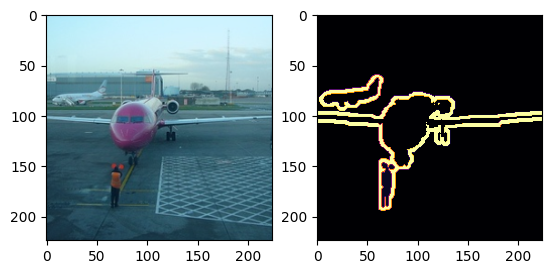

In [4]:
fig, (ax_img, ax_lbl) = plt.subplots(1, 2)

image = einops.rearrange(train_features[0], 'c h w -> h w c')
image = (image + abs(image.min())) / abs(image.max() - image.min()) # undo the preprocessing for display

ax_img.imshow(image)
ax_lbl.imshow(train_labels[0], cmap='inferno')
plt.show()

## part 2: a dataset loader

In [5]:
import h5py
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from typing import Any
import numpy as np
import einops

class ToTensor:
    '''Convert ndarrays to tensors.'''

    def __call__(self, arr):
        return torch.from_numpy(arr)

    
class ScaleToUnit:
    '''convert a label to 0-1'''
    def __call__(self, label):
        return (label + abs(label.min())) / abs(label.max() - label.min())
    
class OneHotTwoClassLabelMatrix:
    '''Convert label ndarrays (NxM) to (NxMx2) one-hot encoded vectors'''

    def __call__(self, label):
        # assumes noclass is 0 and class is 1
        return np.stack(
            [
                1 - label,
                label
            ],
            axis=2
        )

class VOCProjectedDataset(Dataset):
    projection_dataset_file: Path
    projection_split: str
    dataset_handle: str
    transform: Any
    target_transform: Any
    
    labels: np.ndarray
    encodings: np.ndarray

    def __init__(self, projection_set: Path, split: str = 'training', transform=None, target_transform=None):
        '''
        Load a dataset from the voc projected h5 file
        '''
        if type(projection_set) is str:
            projection_set = Path(projection_set)
        assert projection_set.exists()

        # save the transform & dataset info
        self.transform = transform
        self.target_transform = target_transform
        self.projection_dataset_file = projection_set
        self.projection_split = split

        # open the dataset and do some sanity checks
        self.dataset_handle = h5py.File(self.projection_dataset_file, 'r')

        # i regret not using h5's groups for this
        # c'est la vie
        assert f'{split}.encodings' in self.dataset_handle
        assert f'{split}.labels' in self.dataset_handle
        assert self.dataset_handle[f'{split}.encodings'].shape[0] == self.dataset_handle[f'{split}.labels'].shape[0]
        
        self.labels = self.dataset_handle[f'{split}.labels']
        self.encodings = self.dataset_handle[f'{split}.encodings']
        
    def __len__(self):
        return self.labels.shape[0]


    def __getitem__(self, index):
        X = self.encodings[index]
        y = self.labels[index]
        
        if self.transform:
            X = self.transform(X)
        
        if self.target_transform:
            y = self.target_transform(y)
            
        return X, y
    

dataset = VOCProjectedDataset(
    'voc_projection.h5',
    split='train',
    transform=ToTensor(),
    target_transform=Compose([
        ScaleToUnit(),
        OneHotTwoClassLabelMatrix(),
        ToTensor()
    ])
)
print(f'voc dataset on {dataset.projection_split} contains {len(dataset)} elements')


voc dataset on train contains 1464 elements


## part 3: a really simple decoder

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvolutionalDecoder(nn.Module):
    def __init__(self):
        super(ConvolutionalDecoder, self).__init__()
    
        # ngl this is a super big guess
        self.conv1 = nn.ConvTranspose2d(1280, 256, kernel_size=11, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 2, kernel_size=9, stride=6, padding=3, output_padding=5)
        self.bn2 = nn.BatchNorm2d(2)
    
    def forward(self, x):
        # first, convert the (batch) x 256 (heads) x 1280 (head depth) latent rep to Bx1280x16x16
        x = einops.rearrange(x, 'b (h1 h2) d -> b d h1 h2', h1 = 16)
        
        # conv block 1 : 1280x16x16 -> 256x37x37
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # conv block 2 :  256x37x37 -> 2x224x224
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        return x


# part the fourth: can we actually get this thing to train?

In [9]:
# ... todo: finish ...